#Setup

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install matplotlib --upgrade

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Segmentation experiments

In [ ]:
import math
import time
import cv2
import os
import pytesseract
from pytesseract import Output
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
#from deslant_img import deslant_img
import imutils

from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line
from skimage.feature import canny
from skimage.draw import line

# Hyperparameters
img_width = 2100
img_height = 1650
line_dedup_threshold = 10
crop_left_margin = 100
crop_top_margin = 40
crop_dim = 200
min_horizontal_gap = 35

segment_width, segment_height = 100, 25
segment_corners = np.array([(0, segment_height), (segment_width, segment_height), (segment_width, 0), (0, 0)]).astype(np.float32)

# Parameters
root_dir = "/content/gdrive/MyDrive/ErukaLabels/SegmentationExps/"
input_dir = root_dir
output_dir = f"{root_dir}data/ocr/"
cropped_dir = f"{root_dir}data/cropped/"
log_dir = f"{root_dir}logs/"

# Data Structures

In [ ]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.coords_int = [round(x), round(y)]
        self.coords_float = [x, y]

class Line:
    def __init__(self, x, y, slope):
        self.x = x
        self.y = y
        self.slope = slope
        self.is_horizontal = abs(slope) < 1
        # Intercept with the center of the image which is at (crop_dim/2, crop_dim/2)
        if self.is_horizontal:
            self.intercept = self.y - ((self.x - crop_dim/2) * self.slope)
        else:
            self.intercept = self.x - ((self.y - crop_dim/2) / self.slope)

class Box:
    def __init__(self, tl, tr, bl, br):
        self.tl = tl
        self.tr = tr
        self.bl = bl
        self.br = br

        minx = min(tl.x, tr.x, bl.x, br.x)
        maxx = max(tl.x, tr.x, bl.x, br.x)
        miny = min(tl.y, tr.y, bl.y, br.y)
        maxy = max(tl.y, tr.y, bl.y, br.y)

        self.height = maxy - miny
        self.width = maxx - minx

        self.polygon_int = np.array([bl.coords_int, br.coords_int, tr.coords_int, tl.coords_int])
        self.polygon_float = np.array([bl.coords_float, br.coords_float, tr.coords_float, tl.coords_float], dtype=np.float32)

        self.center = Point((minx+maxx)/2, (miny+maxy)/2)
    
    def __str__(self):
        return f"tl: ({self.tl.x},{self.tl.y}) tr: ({self.tr.x},{self.tr.y}) bl: ({self.bl.x},{self.bl.y}) br: ({self.br.x},{self.br.y})"

TODO:
- Cases where building is not detected
- Test stability for more images

(1645, 2115, 3)


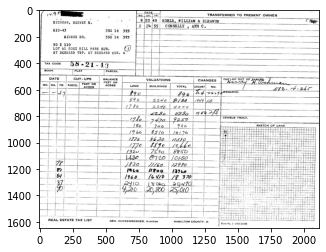

In [ ]:
# img = cv2.imread(f'{input_dir}0020008000300.jpg')
img = cv2.imread(f'{input_dir}5820014039300.jpg')
plt.imshow(img)
print(img.shape)

In [ ]:
# Get locations of the text from Pytesseract
d = pytesseract.image_to_data(img, output_type=Output.DICT)

building_index, total_index, land_index, valuation_index = -999, -999, -999, -999

for index, text in enumerate(d['text']):
    if text.lower() == "buildings":
        building_index = index
    if text.lower() == "total":
        total_index = index
    if text.lower() == 'land':
        land_index = index
    if text.lower() == 'valuations':
        valuation_index = index

756 1034 540 845


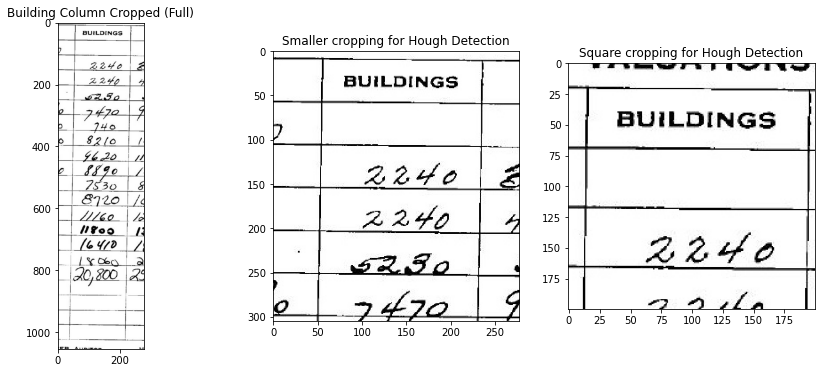

In [ ]:
# Crop image if building found
if building_index != -999:

    b = building_index
    img_cropped_top = d['top'][b] - crop_top_margin
    img_cropped_left = d['left'][b] - crop_top_margin
    img_cropped = img[img_cropped_top:img_cropped_top+crop_dim, img_cropped_left:img_cropped_left+crop_dim]

    width_param_left = 80
    width_param_right = 150
    height_top_cut =15
    height_bottom_cut_col = 50
    height_bottom_cut_hough = 800 ## Note: hough transformation doesn't seem to work on larger image - it only finds the vertical and not the horizontal lines

    # Crop image to smaller set based on values 
    x0 = d['left'][b] - width_param_left
    x1 = x0 + d['width'][b] + width_param_right

    y0 = d['top'][b] - d['height'][b] - height_top_cut
    y1 = img.shape[0] - height_bottom_cut_hough

    y1_full = img.shape[0] - height_bottom_cut_col

    cropped_again = img[y0:y1, x0:x1]

    building_column_cropped = img[y0:y1_full, x0:x1]

    print(x0, x1, y0, y1)

    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    ax = axes.ravel()

    ax[0].imshow(building_column_cropped)
    ax[0].set_title('Building Column Cropped (Full)')
    ax[1].imshow(cropped_again)
    ax[1].set_title('Smaller cropping for Hough Detection')
    ax[2].imshow(img_cropped)
    ax[2].set_title('Square cropping for Hough Detection')
    
else:
    print('building text not found')

# Line Detection

In [ ]:
# Merge horizontal lines that are close together
def dedup_horizontal_lines(raw_lines):
    raw_lines.sort(key=lambda l: l.intercept)
    lines=[]
    merge_count = 1
    for line in raw_lines:
        if len(lines) == 0 or abs(line.intercept - lines[-1].intercept) > line_dedup_threshold:
            lines.append(line)
            merge_count = 1
        else:
            lines[-1] = Line(crop_dim/2, (lines[-1].intercept*merge_count + line.intercept)/(merge_count+1), (lines[-1].slope*merge_count + line.slope)/(merge_count+1))
            merge_count += 1
    return lines

# Ensure minimum horizontal gap between lines
def filter_horizontal_lines(raw_lines):
    lines=[]
    prev_intercept = 0.0
    for i, line in enumerate(raw_lines):
        if i == 0:
            prev_intercept = line.intercept
        elif line.intercept - prev_intercept > min_horizontal_gap:
            lines.append(line)
            prev_intercept = line.intercept
    return lines

def dedup_vertical_lines(raw_lines):
    raw_lines.sort(key=lambda l: l.intercept)
    lines=[]
    merge_count = 1
    for line in raw_lines:
        if len(lines) == 0 or abs(line.intercept - lines[-1].intercept) > line_dedup_threshold:
            lines.append(line)
            merge_count = 1
        else:
            lines[-1] = Line((lines[-1].intercept*merge_count + line.intercept)/(merge_count+1), crop_dim/2, line.slope) # Don't average the slopes
            merge_count += 1
    return lines

def detect_lines(img_cropped):
    # Preprocessing for Hough
    gray = cv2.cvtColor(img_cropped,cv2.COLOR_BGR2GRAY)
    thresh, thresh_image = cv2.threshold(gray, 165, 255, cv2.THRESH_BINARY)
    gray = cv2.convertScaleAbs(thresh_image) # converting the scale
    edges = cv2.Canny(gray, 0, 200)

    # Parameters
    thresh = 10
    min_distance = 15

    # Perform hough transformation
    dimx, dimy = edges.shape
    #diagonal = np.sqrt(dimx**2 + dimy**2)
    #thresh = int(thresh * diagonal)
    # TODO: only scan near horizontal and near vertical lines
    tested_angles = np.linspace(-np.pi, np.pi, 360, endpoint = False)

    # Apply hough lines to retrieve all possible lines
    h, theta, d = hough_line(edges, theta = tested_angles)
    hspace, angles, dists = hough_line_peaks(h, theta, d, thresh, min_distance)
    
    lines = []
    for _, angle, dist in zip(hspace, angles, dists):
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        angle_abs = abs(angle)
        # We are only looking for nearly vertical and horizontal lines so use a pi/8 margin
        if np.pi/8 < angle_abs and angle_abs < 3*np.pi/8:
            continue
        slope = np.tan(angle + np.pi/2)
        lines.append(Line(x0, y0, slope))

    h_lines = [line for line in lines if line.is_horizontal]
    v_lines = [line for line in lines if not line.is_horizontal]

    deduped = dedup_horizontal_lines(h_lines)
    # print(f"Before filtering: {len(deduped)}")
    # filtered = filter_horizontal_lines(deduped)
    # print(f"After filtering: {len(filtered)}")

    # return h_lines, v_lines
    return deduped, dedup_vertical_lines(v_lines)


6 lines were detected
x=100.0, y=20.035398230088497, slope=-6.123233995736766e-17, y_int=20.035398230088497
x=100.0, y=67.87239209708406, slope=0.01745506492821744, y_int=67.87239209708406
x=100.0, y=116.96659504570309, slope=0.01745506492821744, y_int=116.96659504570309
x=100.0, y=165.0588754851666, slope=0.01745506492821744, y_int=165.0588754851666
x=12.281408635355103, y=100.0, slope=-57.28996163075882, x_int=12.281408635355103
x=193.29017002398004, y=100.0, slope=-57.28996163075882, x_int=193.29017002398004


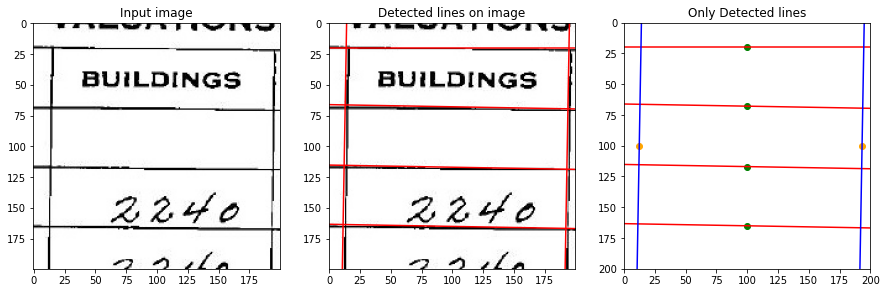

In [ ]:

h_lines, v_lines = detect_lines(img_cropped)

print(f"{len(h_lines) + len(v_lines)} lines were detected")
for line in h_lines:
    print(f"x={line.x}, y={line.y}, slope={line.slope}, y_int={line.intercept}")
for line in v_lines:
    print(f"x={line.x}, y={line.y}, slope={line.slope}, x_int={line.intercept}")

# Plotting results
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(img_cropped)
ax[0].set_title('Input image')
ax[1].imshow(img_cropped)
ax[1].set_title('Detected lines on image')
ax[2].set_title('Only Detected lines')
ax[2].set_xlim(0, crop_dim)
ax[2].set_ylim(crop_dim, 0)
ax[2].set_aspect('equal')

# Horizontal lines
for line in h_lines:
    ax[1].axline((line.x, line.y), slope=line.slope, color='red')
    ax[2].axline((line.x, line.y), slope=line.slope, color='red')
    ax[2].scatter(crop_dim/2, line.intercept, color='green')
# vertical lines
for line in v_lines:
    ax[1].axline((line.x, line.y), slope=line.slope, color='red')
    ax[2].axline((line.x, line.y), slope=line.slope, color='blue')
    ax[2].scatter(line.intercept, crop_dim/2, color='orange')

if len(v_lines) != 2:
    raise RuntimeError("Expected 2 vertical lines")

# Resolve bounding boxes

In [ ]:
## Finding the intersection points

# To avoid some precision bugs
def bound_slope(slope):
    return min(max(slope, -1000), 1000)

def intersection(line1, line2):
    A = np.array([[bound_slope(-line1.slope), 1], 
                  [bound_slope(-line2.slope), 1]])
    b = np.array([[line1.y - bound_slope(line1.slope)*line1.x], 
                  [line2.y - bound_slope(line2.slope)*line2.x]])
    
    x = np.linalg.lstsq(A, b, rcond=-1)[0]
    return Point(x[0][0], x[1][0]) # use lstsq to solve Ax = b, not inv() which is unstable

# Function sourced from this answer: https://stackoverflow.com/a/70371736

def hough_inter(theta1, rho1, theta2, rho2):
    A = np.array([[np.cos(theta1), np.sin(theta1)], 
                  [np.cos(theta2), np.sin(theta2)]])
    b = np.array([rho1, rho2])
    
    return np.linalg.lstsq(A, b)[0] # use lstsq to solve Ax = b, not inv() which is unstable

def resolve_bounding_boxes(h_lines, v_lines):
    # Now loop through all combinations of lines, only checking for intersections if they are of different types
    intersections = []

    for h_line in h_lines:
        for v_line in v_lines:
            intersections.append(intersection(h_line, v_line))

    boxes = []

    for i, h_line in enumerate(h_lines):
        bl = intersection(h_line, v_lines[0])
        br = intersection(h_line, v_lines[1])
        if i > 0:
            boxes.append(Box(tl, tr, bl, br))
        tl = Point(bl.x, bl.y)
        tr = Point(br.x, br.y)
    
    return intersections, boxes



3


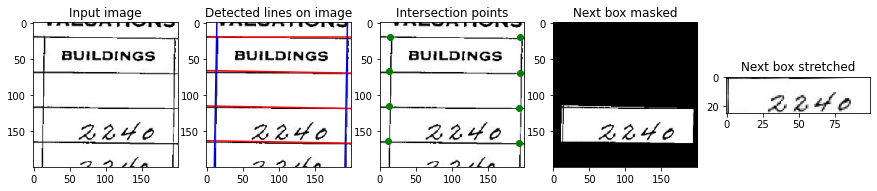

In [ ]:
# Check 
intersections, boxes = resolve_bounding_boxes(h_lines, v_lines)

print(len(boxes))

# Plotting results
fig, axes = plt.subplots(1, 5, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(img_cropped)
ax[0].set_title('Input image')

ax[1].imshow(img_cropped)
ax[1].set_title('Detected lines on image')

# Horizontal lines
for line in h_lines:
    ax[1].axline((line.x, line.y), slope=line.slope, color='red')
# vertical lines
for line in v_lines:
    ax[1].axline((line.x, line.y), slope=line.slope, color='blue')

# Intersection points
ax[2].imshow(img_cropped)
ax[2].set_title('Intersection points')
for i in intersections:
    ax[2].scatter(i.x, i.y, color='green')

# Cropped Box 1
ax[3].set_title('Next box masked')

mask = np.zeros((crop_dim, crop_dim), dtype=np.uint8)
points = boxes[2].polygon_int
cv2.fillPoly(mask, [points], (255, 255, 255))
masked = cv2.bitwise_and(img_cropped,img_cropped,mask = mask)
ax[3].imshow(masked)

# Stretched Box 1
M = cv2.getPerspectiveTransform(boxes[2].polygon_float, segment_corners)
out = cv2.warpPerspective(img_cropped, M,(segment_width, segment_height))

ax[4].set_title('Next box stretched')
ax[4].imshow(out)


In [ ]:
box_d = pytesseract.image_to_data(out, output_type=Output.DICT)

for index, text in enumerate(box_d['text']):
    print(text)





220


#Batch process

Processing file (0/104): 0340A02000100.jpg
Processing file (1/104): 0340A02005600.jpg
Processing file (2/104): 0390A06009600.jpg
Processing file (3/104): 1800A81008100.jpg
Processing file (4/104): 1760A23005900.jpg
Processing file (5/104): 2070B54001300.jpg
Processing file (6/104): 0020008000300.jpg
Processing file (7/104): 0360002014800.jpg
Processing file (8/104): 0360002002600.jpg
Processing file (9/104): 0380006001300.jpg
Processing file (10/104): 0390001014900.jpg
Processing file (11/104): 0380007004200.jpg
Processing file (12/104): 0390003015900.jpg
Processing file (13/104): 0460008010100.jpg
Processing file (14/104): 0410006000500.jpg
Processing file (15/104): 0540002008700.jpg
Processing file (16/104): 0570004001000.jpg
Processing file (17/104): 0560006008100.jpg
Processing file (18/104): 0690003016900.jpg
Processing file (19/104): 0730001021600.jpg
Processing file (20/104): 0750004003600.jpg
Processing file (21/104): 0730001026500.jpg
Processing file (22/104): 0900003007000.jp

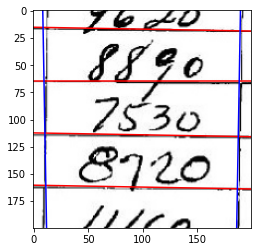

In [ ]:
# Get initial position, this should be the center of the "Buildings" cell
def get_initial_position(img):
    d = pytesseract.image_to_data(img, output_type=Output.DICT)

    building_index, total_index, land_index, valuation_index = -999, -999, -999, -999

    for index, text in enumerate(d['text']):
        if text.lower() == "buildings":
            building_index = index
        if text.lower() == "total":
            total_index = index
        if text.lower() == 'land':
            land_index = index
        if text.lower() == 'valuations':
            valuation_index = index

    if building_index == -999: 
        raise RuntimeError("could not find buildings cell")

    return Point(d['left'][building_index] + d['width'][building_index]/2, d['top'][building_index] + d['height'][building_index]/2)

def interpolate_row_coordinate(a, b, rows):
    new_x = (a.x * (rows-1) + b.x)/rows
    new_y = (a.y * (rows-1) + b.y)/rows
    return Point(new_x, new_y)

def get_next_position(center, img, out_dir, i):

    top = int(center.y - crop_top_margin)
    left = int(center.x - crop_left_margin)

    img_cropped = img[top:top+crop_dim, left:left+crop_dim]
    h_lines, v_lines = detect_lines(img_cropped)

    plt.clf()
    plt.imshow(img_cropped)
    for line in h_lines:
        plt.axline((line.x, line.y), slope=line.slope, color='red')
    for line in v_lines:
        plt.axline((line.x, line.y), slope=line.slope, color='blue')
        
    if len(h_lines) < 3:
        plt.savefig(f"{out_dir}{i}_lines.jpg")
        raise RuntimeError("could not detect at least 3 horizontal lines")
    
    if len(v_lines) != 2:
        plt.savefig(f"{out_dir}{i}_lines.jpg")
        print("Warning: could not detect exactly 2 vertical lines, using defaults")
        v_lines = [Line(10, crop_dim/2, 1000), Line(190, crop_dim/2, 1000)]
    
    intersections, boxes = resolve_bounding_boxes(h_lines, v_lines)

    next_box = boxes[1]
    
    if next_box.height < 35:
        print(f"Warning: box of height {next_box.height} is likely due to a extra horizontal line")
        next_box = boxes[2]

    if next_box.height > 70:
        print(f"Warning: box of height {next_box.height} is likely due to a missing horizontal line")
        rows = round(next_box.height/50)
        next_box = Box(next_box.tl, next_box.tr, interpolate_row_coordinate(next_box.tl, next_box.bl, rows), interpolate_row_coordinate(next_box.tr, next_box.br, rows))


    if not (math.isclose(next_box.height, 50, rel_tol=0.2) and math.isclose(next_box.width, 180, rel_tol=0.2)):
        plt.savefig(f"{out_dir}{i}_lines.jpg")
        raise RuntimeError(f"box dimensions {next_box.width}x{next_box.height} is unexpected")

    M = cv2.getPerspectiveTransform(next_box.polygon_float, segment_corners)
    out = cv2.warpPerspective(img_cropped, M,(segment_width, segment_height))

    return Point(center.x - crop_left_margin + next_box.center.x, center.y - crop_top_margin + next_box.center.y), out
    

# Create clean directory if not exists
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
for f in os.listdir(log_dir):
    os.remove(os.path.join(log_dir, f))

with open(f"{log_dir}log.txt", "w") as l:

    box_count = 0
    all_files = os.listdir(input_dir)
    for file_i, file in enumerate(all_files):
        if not file.endswith(".jpg"):
            continue

        print(f"Processing file ({file_i}/{len(all_files)}): {file}")

        img = cv2.imread(f'{input_dir}{file}')
        img = cv2.resize(img, (img_width, img_height))
        try:
            center = get_initial_position(img)
        except RuntimeError as error:
            l.write(f"Processing failed for {file}: {str(error)}\n")
            continue

        parcel_output_dir = f"{output_dir}{file}/"
        if not os.path.exists(parcel_output_dir):
            os.makedirs(parcel_output_dir)
        for f in os.listdir(parcel_output_dir):
            os.remove(os.path.join(parcel_output_dir, f))

        for i in range(10):
            try:
                center, segmented_img = get_next_position(center, img, parcel_output_dir, i)
                box_count += 1
            except RuntimeError as error:
                if i < 3:
                    l.write(f"Error: Segmentation failed for {file}: {str(error)}\n")
                else:
                    l.write(f"Warn: Segmentation failed for {file}: {str(error)}\n")
                break

            cv2.imwrite(f"{parcel_output_dir}{i}.jpg", segmented_img)
    
    print(f"Box count: {box_count}")

